
<h2 align="left"> 
<img src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png" width="50">
</h2>   


## [**IACS: ComputeFest 2020**](https://www.computefest.seas.harvard.edu/)

#### **Authors/Instructors:**
  Pavlos Protopapas,   Marios Mattheakis, Robbert Struyven,  Camilo Fosco, Vincent Casser



------------


# **Workshop 1 Transfer Learning** 

## How to use existing models for transfer learning 

------------

Welcome to day 2 of ComputeFest 2020! In this workshop, we will explore and play around with the common applications of transfer learning. Transfer learning can be used to improve performance on small datasets, across tasks, and even to recognize and properly process unseen examples.
The flow of the workshop is as follows:

1. **The basics of transfer learning**

2. Transfer learning from classification to segmentation

3. Transfer learning through distillation


## **Goal of the Lab 1**

- Learn the idea of transfer learning through a simple classification example
- Build  new networks by using pre-trained models. Combine  pre-trained layers with new untrained layers and train specific layers.
- Get good performance in image classification and  feature extraction with training in small datasets.  

## **Structure**

0.  Setup

1. Problem Statement
  
  1.1 Performance of the pre-trained  *mobileNet*  
      - Different performance for different categories  

  1.2 Train the mobileNet from scratch (`mobile_from_scratch`)

2. Transfer Learning to the rescue

  2.1 Inspect the extracted features from the pre-trained mobileNet

  2.2 Add and train a new dense layer on top of the pre-trained mobileNet (`mobile_1_layer`)

  2.3 Re-train the last-2 layers of the pre-trained mobileNet (`mobile_2_layers`)

  2.4 Re-train all layers of pre-trained mobileNet 
(`mobile_all_layers`)

  2.5 Fine-tuning of the pre-trained mobileNet (`mobile_tuned`)

----------


# **0. Setup**

Setup the workspace. Connect the colab with the google drive.



**Please make sure that you have loaded the data in your drive**

![alt text](https://i.imgur.com/bxdBm9r.png)

Import the packages and confirm that you import version 2 of tensorflow 

In [12]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt
import os

# Import the TF V2 through this magic command
%tensorflow_version 2.x

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from PIL import Image

# Check the Version of the Tensor Flow. It should be the version 2
print(tf.__version__)

UsageError: Line magic function `%tensorflow_version` not found.


If we have version 2 of TF we proceed by importing Keras and necessary packages

In [13]:
import keras
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from IPython.display import Image
from tensorflow.keras.optimizers import Adam

Colab allows us to use shell commands in the drive directories, such as "ls"

In [14]:
ls  drive/My\ Drive/TransferLearningLab/

ls: cannot access 'drive/My Drive/TransferLearningLab/': No such file or directory


Set the main path for the **working directory**


In [15]:
pathFolder = 'data_Lab1/'

Explore your dataset (images)

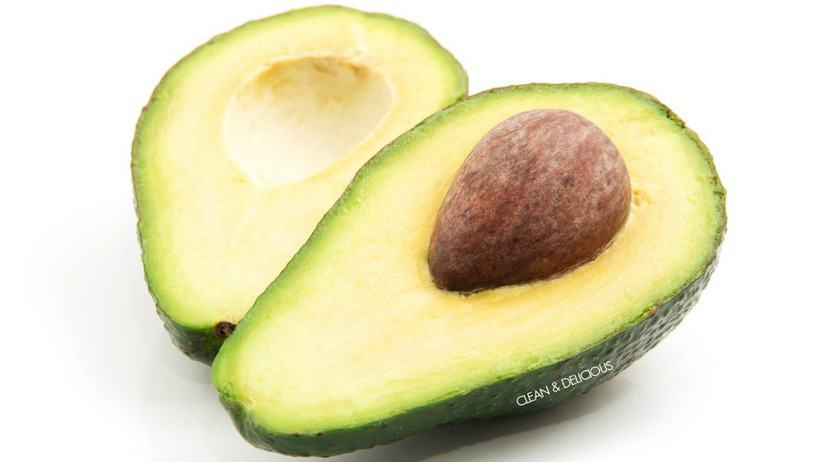

In [16]:
# Image(filename= pathFolder + 'misc_images/German_Shepherd.jpg')
# Image(filename= pathFolder + 'misc_images/blue_tit.jpg')
Image(filename= pathFolder + 'misc_images/avocado_2.jpg')

-----------

# **1. Problem Statement**

The task of this Lab is to design a network for classifying and extracting features for three different categories:  dogs, birds, and fruits. 

Building a new network for each problem is extremely time consuming:
- It needs a lot of effort to optimize the architecture of a network
- For different datasets (e.g. size and type of data) we might need different architectures
- It is difficult to train a network with small datasets

Remedy: Transfer Learning and the use of pre-trained models:
- Here we use MobileNet which is trained in 1000 categories with 1000 images per category.
- This pre-trained model classifies 1000 categories pretty well. But, what if we are interested in some new categories? 
- Pre-trained Mobilenet classifies images and extracts features quite well. In some classes performs better than others. But, what if we are interested in the others? 



## **1.1 Performance of pre-trained MobileNet in  different categories.**

Inspect the performance of the pre-trained mobileNet in new data. It shows different performance for different categories.

Loading the pre-trained MobileNet network

In [17]:
# Choose the weights pretrained in the imagenet dataset
import tensorflow as tf

mobile = tf.keras.applications.mobilenet.MobileNet(weights='imagenet')

Inspect the Mobilenet and define the input shape

In [18]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [19]:
IMG_SIZE  = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

This function prepares the images for the MobileNet: input shape: (1, 224, 224, 3)

In [ ]:
def prepare_image(img_path, img_size = IMG_SIZE):
    img = image.load_img(img_path, target_size=(img_size, img_size))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

Let's make some predictions (classification) by using the pre-trained MobileNet

In [ ]:
imagePath = pathFolder + 'misc_images/German_Shepherd.jpg'
preprocessed_image = prepare_image(imagePath)

# check the size that fits with MobilesNets
print('Image shape: ',(preprocessed_image).shape,'\n \n Prediction:\n ')

# Use mobileNet to classify the image
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
results

It is convenient to define a function to do the classification

In [ ]:
def myClassifier(imagePath, pathFolder=pathFolder, mobile=mobile):
    imagePathFull = pathFolder + imagePath
    preprocessed_image = prepare_image(imagePathFull)
    # Use mobileNet to classify the image
    predictions = mobile.predict(preprocessed_image)
    results = imagenet_utils.decode_predictions(predictions)
    return results

In [ ]:
myClassifier('misc_images/labrador1.jpg')

In [ ]:
myClassifier('misc_images/poodle1.jpg')

So, the pre-trained MobileNet classifies very well the **breed of dogs**.

Let's try now to classify the **breed of birds**.

In [ ]:
myClassifier('misc_images/blue_tit_1.jpg')
# myClassifier('misc_images/blue_tit_2.jpg')

In [ ]:
myClassifier('misc_images/crow_1.jpg')
# myClassifier('misc_images/crow_2.jpg')

In [ ]:
myClassifier('misc_images/hawk_1.jpg')
# myClassifier('misc_images/hawk_2.jpg')

What about **fruits**?

In [ ]:
myClassifier('misc_images/mango_1.jpg')
#myClassifier('misc_images/mango_2.jpg')

In [ ]:
# Image(filename= pathFolder + 'misc_images/avocado_2.jpg')

In [ ]:
myClassifier('misc_images/avocado_1.jpg')
# myClassifier('misc_images/avocado_2.jpg')

In [ ]:
# myClassifier('misc_images/coconuts_1.jpg')
myClassifier('misc_images/coconuts_2.jpg')


### **How can we improve the mobileNet ?**

The pre-trained MobileNet architecture shows quite good performance. Nevertheless, we want to improve  its classification ability  on the classes of birds and fruits. Two possible ways to do that are:


1.  Train the mobileNet from the scratch by using only images  for dogs, birds and fruits

  - Training the MobileNet from the scratch will be overfitting because our dataset is too small and the network very expressive. 

2.   Use the pre-trained model a re-train just a few layers (fast and efficient).
This is  a simple way to apply Transfer Learning methodology. 

  *  The convolution layers of the MobileNet can extract  abstract features from the images.  We can use (transfer) this knowledge by  keeping those pre-trained layers. 
  * We can adjust and train a few new layers to classify the new data from the extracted features



<!-- As example,  we want to classify different breed of birds and fruits where the pre-trained mobileNet fails. 
* First, let's explore that the MobileNet indeed extract and learn abstract features
* Then add a new dense fully connected layer (classifier) and train it. Try to add more dense layers.
* Check the classification performance on the new task. Is it better than before?  -->





## **1.3 Train the mobileNet from the scratch (`mobile_from_scratch`)**


Load the data into the ImageDataGenerator

We use data augmentation:

 https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/ 


In [ ]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input,
                                                  horizontal_flip=True, 
                                                  rotation_range=45, 
                                                  zoom_range=[0.8,1.0]) 

test_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) 


# Count the number of groups and make an array with their names

# TRAINING set
pathTrain = pathFolder + 'trainData/'
listGroupsTrain = os.listdir(pathTrain) # the directory path

# TESTING set
pathTest = pathFolder + 'testData/'
listGroupsTest = os.listdir(pathTest) # the directory path

# Load the data into the ImageDataGenerator
train_generator=train_datagen.flow_from_directory(pathFolder+'trainData',
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=64,
                                                 class_mode='categorical',
                                                 shuffle=True, 
                                                 classes=listGroupsTrain)
                                                 
test_generator=test_datagen.flow_from_directory(pathFolder+'testData',
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=64,
                                                 class_mode='categorical',
                                                 shuffle=False, 
                                                 classes=listGroupsTest)

**Load and train the un-trained MobileNet**

In [ ]:
# Loading the un-trained weights model
mobile_from_scratch = tf.keras.applications.mobilenet.MobileNet(input_shape=IMG_SHAPE, weights=None, 
                                                                classes=len(listGroupsTrain))

# Compile the model with a ADAM optimizers and a Crossentropy loss function
# mobile_from_scratch.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])      
lrate = 0.001
mobile_from_scratch.compile(optimizer=tf.keras.optimizers.Adam(lr=lrate),loss='categorical_crossentropy',metrics=['accuracy'])      


step_size_train=train_generator.n//train_generator.batch_size


In [ ]:
# Train the model and save the loss and accuracy of the training
# and validation data in the history variable
historyModel_scratch = mobile_from_scratch.fit_generator(generator=train_generator,
                                                         validation_data=test_generator,
                                                         steps_per_epoch=step_size_train,
                                                         epochs=10)          

In [ ]:
def plot_history(histories, titles, clrs='red'):
  # helper function to plot the loss and accuracy 
  plt.figure(figsize=(18, 7))
  # for history, title in zip(histories,titles):
  for history, title, clr in zip(histories,titles,clrs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

# color='green', marker='o', linestyle='dashed'
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(acc)+1), acc, color=clr, label='Training Accuracy: ' + title)
    plt.plot(range(1, len(acc)+1), val_acc, color=clr, linestyle='dashed', label='Validation Accuracy: ' + title)
    plt.legend()
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(acc)+1), loss, color=clr,  label='Training Loss: ' + title)
    plt.plot(range(1, len(acc)+1), val_loss, color=clr, linestyle='dashed', label='Validation Loss: ' + title)
    plt.legend()
    plt.ylabel('Cross Entropy')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
  plt.show()

**Plot our training and validation loss and accuracy**

In [ ]:
histories = [historyModel_scratch]
titles = ['model from scratch']
clr = ['green']

plot_history(histories, titles, clr)

We are overfitting the MobileNet very fast. It makes sense, the network is too expressive and the dataset too small. 

So, how can we take an advantage of this efficient network?

---------------


# **2. Transfer Learning to the rescue**

## **2.1 Explore the pre-trained mobileNet features**

 MobileNet is able to extract abstract features from images. Inpsecting the network will figure out which *transfer values* we need.

Let's extract the features that MobileNet learns for three  images, one from each category of dogs, birds, and fruits.

In [ ]:
preprocessed_image1 = prepare_image(pathFolder + 'misc_images/German_Shepherd.jpg')
preprocessed_image2 = prepare_image(pathFolder + 'misc_images/hawk_1.jpg')
preprocessed_image3 = prepare_image(pathFolder + 'misc_images/mango_1.jpg')

Inspect the first convolution layer: `conv1`

Load only up to the first convolution layer. We need to know the name of the layer (check with `*.summary()`)


In [ ]:
# load the model up to first convolution layers
inspectLayerModel = tf.keras.models.Model(inputs=mobile.input, outputs=mobile.get_layer('conv1').output)

features1 = inspectLayerModel.predict(preprocessed_image1)
features2 = inspectLayerModel.predict(preprocessed_image2)
features3 = inspectLayerModel.predict(preprocessed_image3)

print('shape: ', features1.shape , '\n')
print('type: ',type(features1), '\n')

# Plot the first N features for each image
N=5
plt.figure(figsize=[16,8])
for i in range(N):
    # i in a different feature of each imge
    plt.subplot(3,N,i+1)
    plt.imshow(features1[0,:,:,i])
    plt.subplot(3,N,N+i+1)
    plt.imshow(features2[0,:,:,i])
    plt.subplot(3,N,2*N + i+1)
    plt.imshow(features3[0,:,:,i])

Inspect one layer deeper: `conv_pw_1`

In [ ]:
inspectLayerModel = tf.keras.models.Model(inputs=mobile.input, outputs=mobile.get_layer('conv_pw_1').output)

features1 = inspectLayerModel.predict(preprocessed_image1)
features2 = inspectLayerModel.predict(preprocessed_image2)
features3 = inspectLayerModel.predict(preprocessed_image3)

print('shape: ', features1.shape , '\n')

plt.figure(figsize=[16,8])
for i in range(N):
    plt.subplot(3,N,i+1)
    plt.imshow(features1[0,:,:,i])
    plt.subplot(3,N,N+i+1)
    plt.imshow(features2[0,:,:,i])
    plt.subplot(3,N,2*N + i+1)
    plt.imshow(features3[0,:,:,i])

Inpsect the last convolution layer: `conv_pw_13`

In [ ]:
inspectLayerModel = tf.keras.models.Model(inputs=mobile.input, outputs=mobile.get_layer('conv_pw_13_relu').output)

features1 = inspectLayerModel.predict(preprocessed_image1)
features2 = inspectLayerModel.predict(preprocessed_image2)
features3 = inspectLayerModel.predict(preprocessed_image3)

print('shape: ', features1.shape, '\n')

plt.figure(figsize=[16,8])
for i in range(N):
    plt.subplot(3,N,i+1)
    plt.imshow(features1[0,:,:,i])
    plt.subplot(3,N,N+i+1)
    plt.imshow(features2[0,:,:,i])
    plt.subplot(3,N,2*N + i+1)
    plt.imshow(features3[0,:,:,i])


Totally abstract features. Let's check for similarities between similar pictures

In [ ]:
preprocessed_image1b = prepare_image(pathFolder + 'misc_images/labrador1.jpg')
preprocessed_image2b = prepare_image(pathFolder + 'misc_images/hawk_2.jpg')
preprocessed_image3b = prepare_image(pathFolder + 'misc_images/mango_2.jpg')

features1 = inspectLayerModel.predict(preprocessed_image1)
features1b = inspectLayerModel.predict(preprocessed_image1b)
features2 = inspectLayerModel.predict(preprocessed_image2)
features2b = inspectLayerModel.predict(preprocessed_image2b)
features3 = inspectLayerModel.predict(preprocessed_image3)
features3b = inspectLayerModel.predict(preprocessed_image3b)



plt.figure(figsize=[16,8])
for i in range(N):
    plt.subplot(2,N,i+1)
    plt.imshow(features2[0,:,:,i])
    plt.subplot(2,N,N+i+1)
    plt.imshow(features2b[0,:,:,i])
    


The features seem  meaningless,  but is that true?

Let's explore those features by using a dimensional reduction method such as Principle Component Analysis (PCA). 

**PCA for further analysis of transfer values:**

To save some time we use only 20 images per category. These data are store at `pcaData`.




Define the layer from which we will extract the features

In [ ]:
# featuresLayerModel = tf.keras.models.Model(inputs=mobile.input, outputs=mobile.get_layer('conv_pw_13_relu').output)

# ALTERNATIVELY

featuresLayerModel = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE, weights='imagenet', include_top=False)

Count the images in the PCA dataset and define an array with the associate name of category of each image

In [ ]:
# location
pathPCA = pathFolder + 'pcaData/'

# groups
listGroups = os.listdir(pathPCA) # the directory path
number_groups = len(listGroups)

# count the pictures
totalImages = 0
for pathF in listGroups:
    pathF1 = pathPCA + pathF
    listFiles = os.listdir(pathF1) 
    totalImages += len(listFiles)

In [ ]:
# PCA take a 1D object per image
features_flatten = np.zeros([totalImages,7*7*1024]) 

i=0
for pathF in listGroups:
    pathF1 = pathPCA + pathF + "/"
    for imgName in os.listdir(pathF1):
        pathImag = pathF1 + imgName
        preprocessed_img = prepare_image(pathImag)
        features = featuresLayerModel.predict(preprocessed_img)
        features_flatten[i,:] = features.flatten()
        i += 1        

Perform a PCA transform in the extracted features

In [ ]:
pca = PCA(n_components=2)
transferValues = features_flatten
transferVal_pca = pca.fit_transform(transferValues)

Plot the features after PCA transform and dimensionsal reduction

In [ ]:
x = transferVal_pca[:, 0]
y = transferVal_pca[:, 1]

mystyle = ['ok', 'or','^m','^y','*r','*k', '*b','ob']

plt.figure(figsize=[14,10])

# The number of images per category in the pca dataset 
imgC = 20

for i in range(number_groups):
    plt.plot(x[i*imgC : imgC*(i+1)],y[i*imgC : imgC*(i+1)], mystyle[i], label=listGroups[i] )
plt.legend();

 ## **2.2 Add and train  a new dense layer on the top of the pre-trained MobileNet (`mobile_1_layer`)**


The plan is to use the pre-trained convolution layers obtained by MobileNet (base model), adjust a new dense layer in the end (classifier). Then freeze the base layers and train only the classifier.

We are interested only in 8 classes.

In [ ]:
# Count the number of groups and make an array with their names
pathTrain = pathFolder + 'trainData/'
listGroupsTrain = os.listdir(pathTrain) # the directory path

pathTest = pathFolder + 'testData/'
listGroupsTest = os.listdir(pathTest) # the directory path

number_groupsTrain = len(listGroupsTrain)
print(number_groupsTrain, 'new groups')

Define the **base model**

In [ ]:
transferModel_base = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE, weights='imagenet', include_top=False)

In [ ]:
# transferModel_base.summary()

Create the new architecture by transfering the convolutions layers from the mobilenet. 



In [ ]:
# Freeze the mobileNet's layers
transferModel_base.trainable = False

# Regularize the dense layer by using L1
kernel_weight = 0.02
bias_weight = 0.02

mobile_1_layer = tf.keras.Sequential([
      transferModel_base,
      tf.keras.layers.GlobalAveragePooling2D(),
## You might want to add an extra dense layer
      # Dense(32, activation='relu',
      #                        kernel_regularizer=tf.keras.regularizers.l1(kernel_weight), 
      #                        bias_regularizer=tf.keras.regularizers.l1(bias_weight)),
      Dense(number_groupsTrain, activation='softmax', name="dense_head",
                                 kernel_regularizer=tf.keras.regularizers.l1(kernel_weight), 
                                 bias_regularizer=tf.keras.regularizers.l1(bias_weight))
])


mobile_1_layer.summary()

Compile the model: Define optimizer, loss function, and the number of training period (epochs). 

It  takes a few minutes

In [ ]:
# Adam optimizer, loss function will be categorical cross entropy
lrate = 0.002
mobile_1_layer.compile(optimizer=tf.keras.optimizers.Adam(lr=lrate),
                     loss='categorical_crossentropy' ,metrics=['accuracy'])

In [3]:
step_size_train=train_generator.n//train_generator.batch_size

history_mobile_1_layer = mobile_1_layer.fit_generator(generator=train_generator,
                                       validation_data=test_generator,
                                       steps_per_epoch=step_size_train,
                                       epochs=10)

NameError: name 'train_generator' is not defined

**Check the performance**

In [ ]:
histories = [historyModel_scratch, history_mobile_1_layer]
titles = ['model from scratch', '1 layer re-trained']
clrs = ['green', 'red']
plot_history(histories, titles, clrs)


##  **2.3 Re-train the last-2 layers of pre-trained mobileNet (`mobile_2_layers`)**

During the training of the previoius new model we had frozen the pre-trained layers got by mobileNet. So, by doing PCA in the features (as we did earlier) we will not see any change. We can improve the features extracted by also training the last convolution layer of the new model

In [ ]:
transferModel_base_fine_tuned_2_layers = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE, weights='imagenet', include_top=False)

transferModel_base_fine_tuned_2_layers.trainable = False

In [ ]:
# The number of the layers in the base model
NumOfLayers = len(transferModel_base_fine_tuned_2_layers.layers)
print("Number of layers in the base model: ", NumOfLayers)

# Earlier we froze all the layers by: transferModel_base.trainable = False
# Print out  the name of the layers to  decide which to un-freeze
i = 1
for layer in transferModel_base_fine_tuned_2_layers.layers[:NumOfLayers]:
    print(i,layer.name)
    i+=1


In [ ]:
# Fine-tune only the last convolution: (be careful, the last is  relu, we don;t need that)
i = NumOfLayers-3
for layer in transferModel_base_fine_tuned_2_layers.layers[NumOfLayers-3:NumOfLayers]:
    layer.trainable =  True
    print(i,layer.name)
    i+=1

mobile_2_layers = tf.keras.Sequential([
  transferModel_base_fine_tuned_2_layers,
  tf.keras.layers.GlobalAveragePooling2D(),
Dense(number_groupsTrain, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l1(kernel_weight), 
                           bias_regularizer=tf.keras.regularizers.l1(bias_weight))
])

In [ ]:
mobile_2_layers.compile(optimizer=tf.keras.optimizers.Adam(lr=lrate),
                     loss='categorical_crossentropy' ,metrics=['accuracy'])


step_size_train=train_generator.n//train_generator.batch_size

history_mobile_2_layers = mobile_2_layers.fit_generator(generator=train_generator,
                                                  validation_data=test_generator,
                                                  steps_per_epoch=step_size_train,
                                                  epochs=10)


**Compare the performance for the 1 versus 2 layers re-training**

In [ ]:
histories = [history_mobile_1_layer, history_mobile_2_layers]
titles = ['1 layer re-trained', '2 layer re-trained']
clrs = ['red', 'orange']

plot_history(histories, titles, clrs)

**Inspect what happens with the features**

Define first a function to perform PCA transform and make the plot

In [ ]:
def plot_feature_extraction(transferModel_base):
  featuresTunedModel = tf.keras.models.Model(inputs=transferModel_base.input,
                                             outputs=transferModel_base.get_layer('conv_pw_13_relu').output)


  # Count the number of groups and make an array with their names
  pathPCA = pathFolder + 'pcaData/'
   
  listGroups = os.listdir(pathPCA) # the directory path
  number_groups = len(listGroups)

  totalImages = 0
  for pathF in listGroups:
      pathF1 = pathPCA + pathF
      listFiles = os.listdir(pathF1) 
      totalImages += len(listFiles)


  features_tuning = np.zeros([totalImages,7*7*1024]) # for using the conv_pw_13 layer

  i=0
  for pathF in listGroups:
      pathF1 = pathPCA + pathF + "/"
      for imgName in os.listdir(pathF1):
          pathImag = pathF1 + imgName
          preprocessed_img = prepare_image(pathImag)
          features = featuresTunedModel.predict(preprocessed_img)

          features_tuning[i,:] = features.flatten()
          i += 1        

  pcaT = PCA(n_components=2)
  transferValues = features_tuning
  transferVal_pcaT = pcaT.fit_transform(transferValues)

  x = transferVal_pcaT[:, 0]
  y = transferVal_pcaT[:, 1]

  mystyle = ['ok', 'or','^m','^y','*r','*k', '*b','ob']

  imgC = 20

  plt.figure(figsize=[12,8])
  for i in range(number_groups):
    plt.plot(x[i*imgC : imgC*(i+1)],y[i*imgC : imgC*(i+1)], mystyle[i], label=listGroups[i] )
  plt.legend();


In [ ]:
plot_feature_extraction(transferModel_base_fine_tuned_2_layers)


Compared to previously when only the last dense layer was trained and the feature extraction convolutional layers where exactly the ones from the pre-trained Imagenet model:

In [ ]:
plot_feature_extraction(transferModel_base)

## **2.4 Re-train all layers of pre-trained mobileNet (`mobile_all_layers`)**



In [ ]:
transferModel_base_fine_tuned_all_layers = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE, weights='imagenet', include_top=False)

# Train the entire network
transferModel_base_fine_tuned_all_layers.trainable = True


mobile_all_layers = tf.keras.Sequential([
  transferModel_base_fine_tuned_all_layers,
  tf.keras.layers.GlobalAveragePooling2D(),
  Dense(number_groupsTrain, activation='softmax',
                         kernel_regularizer=tf.keras.regularizers.l1(kernel_weight), 
                          bias_regularizer=tf.keras.regularizers.l1(bias_weight))
])


mobile_all_layers.compile(optimizer=tf.keras.optimizers.Adam(lr=lrate),
                     loss='categorical_crossentropy' ,metrics=['accuracy'])


step_size_train=train_generator.n//train_generator.batch_size

history_mobile_all_layers = mobile_all_layers.fit_generator(generator=train_generator,
                                                  validation_data=test_generator,
                                                  steps_per_epoch=step_size_train,
                                                  epochs=10)

**Let's compare the loss and accuracy for the 1 versus 2 and versus all  layers re-training**

In [ ]:
histories = [history_mobile_1_layer, history_mobile_2_layers, history_mobile_all_layers]
titles = ['1 layer re-trained', '2 layers re-trained', 'all layers re-trained' ]
clrs = ['red', 'orange', 'black']
plot_history(histories, titles, clrs)

**Inspect what happened with the features**

In [ ]:
plot_feature_extraction(transferModel_base_fine_tuned_all_layers)

## **2.5 Fine-tuning**

We use the first architecture where we  trained only the classifier layer. Now, we unfreeze the convolution layers and keep training the entire network

In [ ]:
mobile_1_layer.summary()

In [ ]:
# unfreeze the convolution layers
transferModel_baseTune = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE, weights='imagenet', include_top=False)
transferModel_baseTune.trainable = True

# re-define the architecture
mobile_tuned = tf.keras.Sequential([
  transferModel_baseTune,
  tf.keras.layers.GlobalAveragePooling2D(),
  mobile_1_layer.get_layer('dense_head')
])


In [ ]:
mobile_tuned.summary()

In [ ]:
mobile_tuned.compile(optimizer=tf.keras.optimizers.Adam(lr=lrate),
                     loss='categorical_crossentropy' ,metrics=['accuracy'])


step_size_train=train_generator.n//train_generator.batch_size

history_mobile_tuned = mobile_tuned.fit_generator(generator=train_generator,
                                                  validation_data=test_generator,
                                                  steps_per_epoch=step_size_train,
                                                  epochs=10)

Performance

In [ ]:
histories = [history_mobile_1_layer, history_mobile_2_layers, history_mobile_all_layers, history_mobile_tuned]
titles = ['1 layer re-trained', '2 layers re-trained', 'all layers re-trained', 'tuning']
clrs = ['red', 'orange', 'black', 'blue']

plot_history(histories, titles, clrs)

**Features inspection**

In [ ]:
plot_feature_extraction(transferModel_baseTune)

## **Conclusion:**

**Transfer learning  for classification:**

Training a deep network (such as mobileNet, inception, VGG etc) from the scratch is time consuming. Designing a new network to classify a particular dataset requires a lot of effort (hyperparameter optimization etc). We might use a pre-trained deep network  and re-train only a few new layers. In particular, we can use the convolution layers that already have been trained to extract features and add on the top one or more dense layers, the classifier block. We freeze the convolution layers and train only the classifier block of layers on a certain dataset. *This proccess improves the classification but does not improve the feature extraction.*


**Fine tuning for feature extraction:**

When we are working with a small dataset it is difficult to train a network to extract features. On the other hand, a pre-trained model that has been trained on a big dataset is able to extract features much better. However, it might not perform very well in extracting features for a particular dataset. In that case we can improve the feature extraction by fine tuning. First, we  freeze  the pre-trained convolution layers and train the new classifier layers (dense). Once we have trained the classifier we unfreeze the convolution layers and keep training the entire network.



## **References**

- https://towardsdatascience.com/transfer-learning-using-mobilenet-and-keras-c75daf7ff299
- https://www.alibabacloud.com/blog/part-3-image-classification-using-features-extracted-by-transfer-learning-in-keras_595291
- https://www.tensorflow.org/tutorials/images/transfer_learning



# **END OF NOTEBOOK**

----------------------

## **Extension**


**Download data**

We can download  images very easy from Google Image Search. To save sometime we have done this for you. But there is the code to download images:

In [ ]:
## An example to download images for crows from google_image package 

# !pip install google_images_download
# from google_images_download import google_images_download
# response = google_images_download.googleimagesdownload()
# arguments = {"keywords":"crow","limit":100,"print_urls":False, "format":"jpg", "size":">400*300"}
# paths = response.download(arguments)